In [1]:
from dep_tools.searchers import PystacSearcher
from dep_tools.loaders import OdcLoader
from dep_tools.grids import grid

from dep_tools.s2_utils import mask_clouds

from odc.stac import configure_rio

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set up rasterio
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

# Initialise the grid
PACIFIC_GRID_10 = grid(10, return_type="GridSpec")

In [4]:
# Study site configuration
item_id = "63,20"  # West viti levu
datetime = "2024-09"


# And get the study site
tile_index = tuple(int(i) for i in item_id.split(","))
geobox = PACIFIC_GRID_10.tile_geobox(tile_index)

# Load low-res if you want it faster
geobox = geobox.zoom_out(10)

geobox.explore()

In [5]:
# Search for data
searcher = PystacSearcher(
    catalog="https://earth-search.aws.element84.com/v1",
    collections=["sentinel-2-c1-l2a"],
    datetime=datetime,   
)

items = searcher.search(area=geobox)
print(f"Found {len(items)} items")

Found 42 items


In [6]:
# Set up a data loader
loader = OdcLoader(
    bands=["scl", "red", "blue", "green"],
    chunks=dict(time=1, x=3201, y=3201),
    groupby="solar_day",
    fail_on_error=False,
)

# Run the load process, which is lazy-loaded
data = loader.load(items, areas=geobox)
data

<xarray.Dataset> Size: 77MB
Dimensions:      (y: 960, x: 960, time: 12)
Coordinates:
  * y            (y) float64 8kB -1.984e+06 -1.984e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 8kB 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 96B 2024-09-02T22:30:56.998000 ... 202...
Data variables:
    scl          (time, y, x) uint8 11MB dask.array<chunksize=(1, 960, 960), meta=np.ndarray>
    red          (time, y, x) uint16 22MB dask.array<chunksize=(1, 960, 960), meta=np.ndarray>
    blue         (time, y, x) uint16 22MB dask.array<chunksize=(1, 960, 960), meta=np.ndarray>
    green        (time, y, x) uint16 22MB dask.array<chunksize=(1, 960, 960), meta=np.ndarray>

In [7]:
data = data.compute()

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


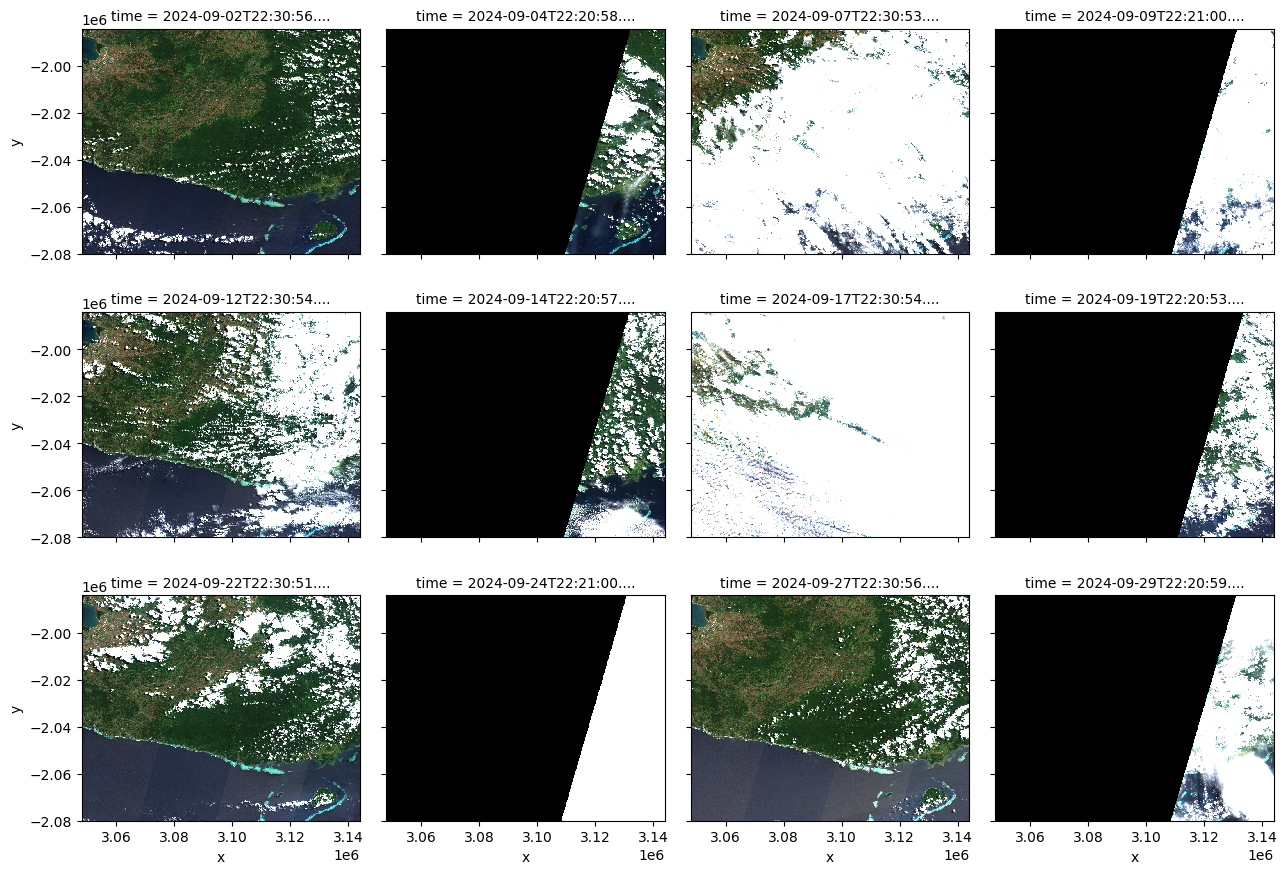

In [8]:
data[["red", "green", "blue"]].to_array().plot.imshow(col="time", col_wrap=4, vmin=1000, vmax=3000)

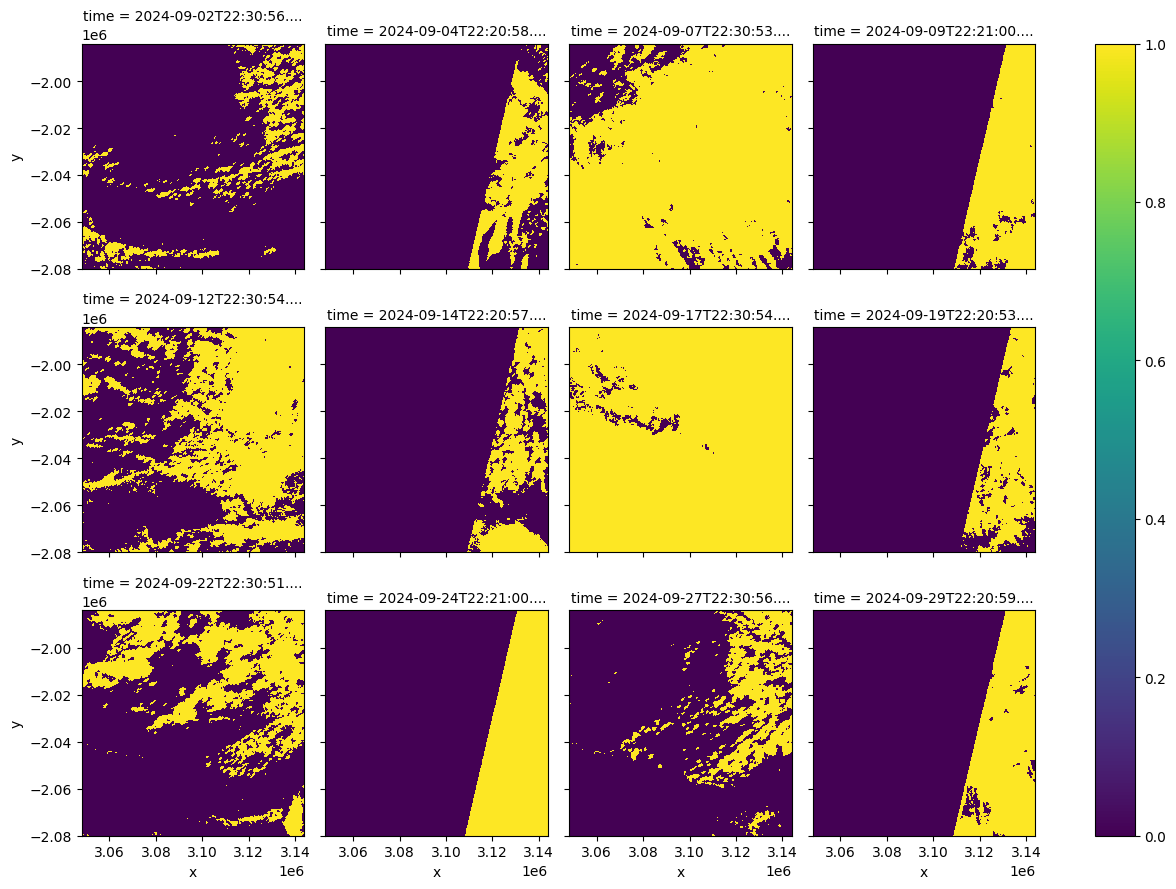

In [9]:
masked, mask = mask_clouds(data, filters=[("dilation", 3), ("erosion", 2)], return_mask=True)

mask.plot.imshow(col="time", col_wrap=4)

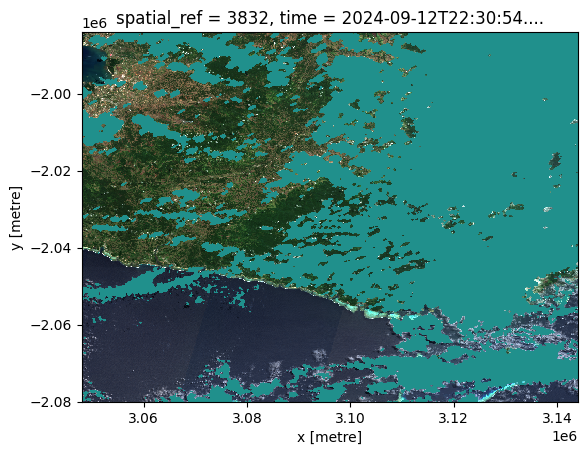

In [10]:
import folium
import numpy as np

TIMESTEP = 4

masked, mask = mask_clouds(data, filters=[("dilation", 3), ("erosion", 2)], return_mask=True)
# mask.attrs = {"nodata": np.nan, "_FillValue": np.nan}

mask_nan = mask.where(mask != 0, np.nan)

data.isel(time=TIMESTEP)[["red", "green", "blue"]].to_array().plot.imshow(vmin=1000, vmax=3000,)
mask_nan.isel(time=TIMESTEP).plot.imshow(add_colorbar=False,)

In [11]:
m = folium.Map(location=geobox.geographic_extent.centroid.coords[0][::-1], zoom_start=10)

data.isel(time=TIMESTEP).odc.to_rgba(vmin=1000, vmax=3000).odc.add_to(m, name="RGB")
mask.isel(time=TIMESTEP).odc.add_to(m, name="Cloud Mask")

folium.LayerControl().add_to(m)

m